# Consultas 

## Definição da Constelação de Fatos

**Tabelas de dimensão**

- dim_data (data_pk, data_completa, data_dia, data_mes, data_semestre, data_ano)
- dim_localidade (localidade_pk, latitude, longitude, cidade, estado, regiao, pais)
- dim_tipo_cancer (tipo_cancer_pk, tipo_cancer, mortalidade, taxa_incidencia_total)
- dim_faixa_etaria (faixa_pk, faixa_idade, idade_min, idade_max, id_idade)
- dim_metrica (metrica_pk, tipo_metrica)
- dim_sexo (sexo_pk, sexo)

**Tabelas de fatos**

- fato_cancer (ano_pk, estado_pk, tipo_cancer_pk, sexo_pk, faixa_pk, metrica_pk, obitos_cancer, incidencia_cancer, prevalencia_cancer)
- fato_clima (data_pk, localidade_pk, temperatura_media, temperatura_max, temperatura_min, radiacao_uv, radiacao_uva, radiacao_uvb, precipitacao)

**Views**

- vw_cidade (localidade_pk, latitude, longitude, clima_cidade, clima_estado, clima_regiao, clima_pais)
- vw_estado (estado_pk, cancer_regiao, cancer_pais)
- vw_dia (data_pk, clima_data_completa, clima_dia, clima_mes, clima_semestre, clima_ano)
- vw_ano (ano_pk, cancer_ano, cancer_decada)

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

load_dotenv()

DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

engine = create_engine(f'postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')


### Exemplo

In [2]:
query = """
SELECT
    e.cancer_estado,
    SUM(CAST(f.obitos_cancer AS FLOAT)) AS total_obitos,
    SUM(CAST(f.incidencia_cancer AS FLOAT)) AS total_incidencia,
    SUM(CAST(f.prevalencia_cancer AS FLOAT)) AS total_prevalencia
FROM
    fato_cancer f
JOIN
    vw_estado e ON e.estado_pk = f.estado_pk
JOIN
    dim_metrica m ON m.metrica_pk = f.metrica_pk
WHERE
    m.tipo_metrica LIKE 'Taxa'
GROUP BY
    e.cancer_estado
ORDER BY
    total_incidencia DESC;
"""


df = pd.read_sql(query, engine)
df

,cancer_estado,total_obitos,total_incidencia,total_prevalencia
0,Goiás,12993.047,392710.720,57159.055
1,Sergipe,15960.374,392537.802,52663.525
2,Santa Catarina,23858.165,391199.102,67607.390
3,São Paulo,15374.809,282108.022,53571.422
4,Minas Gerais,9120.450,233174.681,39857.006
5,Mato Grosso,11680.209,230390.188,48306.518
6,Distrito Federal,26481.694,208781.710,37977.507
7,Rio Grande do Norte,13472.383,171378.065,30430.556
8,Mato Grosso do Sul,14236.132,158181.056,35014.882
9,Rio Grande do Sul,17386.718,158019.762,41719.777


-------

# Roll-Up

### Qual seria a Precipitação média de cada Estado?

In [35]:
query = """
SELECT
    a.estado, AVG(CAST(f.precipitacao AS DECIMAL)) AS media_precipitacao
FROM
    fato_clima f 
JOIN
    dim_localidade a ON a.localidade_pk = f.localidade_pk
GROUP BY
    a.estado
ORDER BY
    media_precipitacao DESC;
"""

df = pd.read_sql(query, engine)
df.head()

,estado,media_precipitacao
0,Amazonas,6.065025
1,Pará,5.862740
2,Amapá,5.826249
3,Acre,4.840113
4,Santa Catarina,4.462997


In [36]:
import geopandas as gpd

shapefile_path = 'data/bcim_2016_21_11_2018.gpkg' 
info_brasil = gpd.read_file(shapefile_path, layer='lim_unidade_federacao_a')
info_brasil.rename({'nome': 'estado'}, axis=1, inplace=True)

precipitacao_estados = info_brasil.merge(df, on='estado', how='left')


<Axes: >

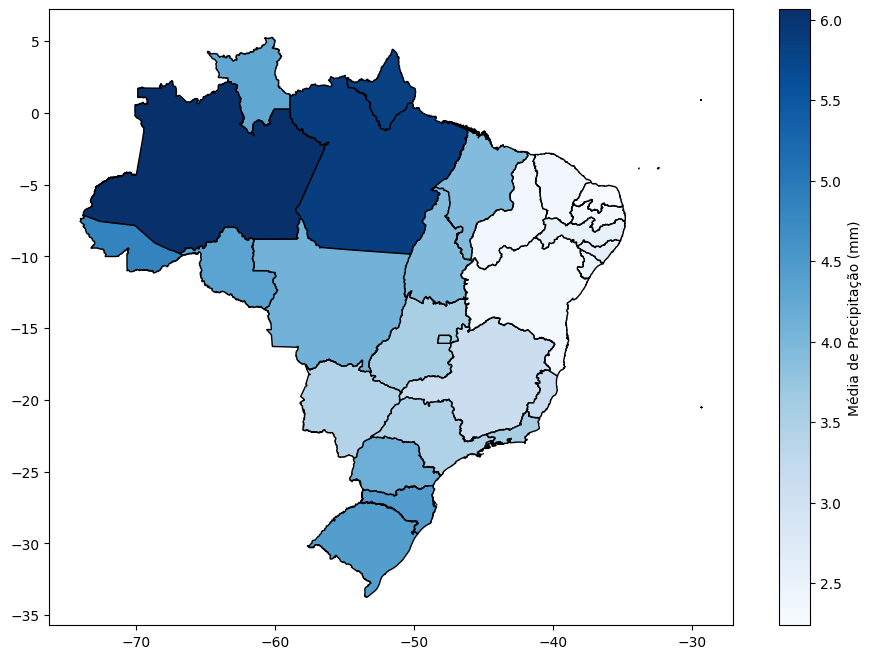

In [37]:
precipitacao_estados.plot(column='media_precipitacao', cmap='Blues', legend=True, figsize=(12, 8), edgecolor='black', legend_kwds={"label": "Média de Precipitação (mm)", "orientation": "vertical"},)

### Qual a temperatura média de uma região?

In [38]:
query = """
SELECT
    a.estado, AVG(CAST(f.temperatura_media AS DECIMAL)) AS temperatura_media
FROM
    fato_clima f 
JOIN
    dim_localidade a ON a.localidade_pk = f.localidade_pk
GROUP BY
    a.estado
ORDER BY
    temperatura_media DESC;
"""

df = pd.read_sql(query, engine)
df.head()

,estado,temperatura_media
0,Piauí,27.852664
1,Maranhão,27.382270
2,Ceará,27.060568
3,Rio Grande do Norte,27.025015
4,Tocantins,26.859412


<Axes: >

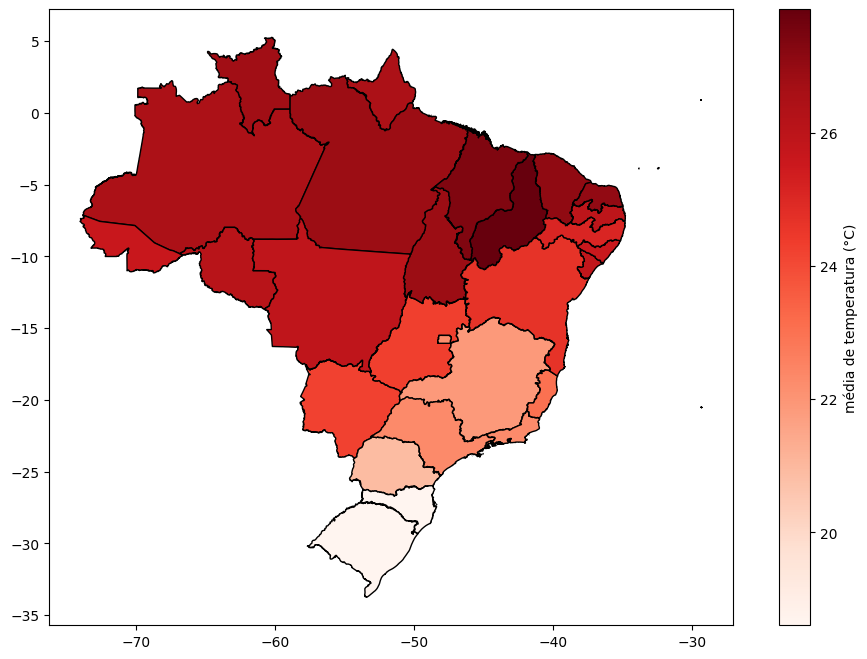

In [42]:
precipitacao_estados = info_brasil.merge(df, on='estado', how='left')
precipitacao_estados.plot(column='temperatura_media',
                        cmap='Reds',
                        legend=True,
                        figsize=(12, 8),
                        edgecolor='black',
                        legend_kwds={"label": "média de temperatura (°C)",
                                      "orientation": "vertical"})

### Qual o número total de casos de câncer de pele em uma região do Brasil?

In [44]:
query = """
SELECT
    e.cancer_estado,
    SUM(CAST(f.obitos_cancer AS FLOAT)) AS total_obitos,
    SUM(CAST(f.incidencia_cancer AS FLOAT)) AS total_incidencia,
    SUM(CAST(f.prevalencia_cancer AS FLOAT)) AS total_prevalencia
FROM
    fato_cancer f
JOIN
    vw_estado e ON e.estado_pk = f.estado_pk
JOIN
    dim_metrica m ON m.metrica_pk = f.metrica_pk
WHERE
    m.tipo_metrica LIKE 'Taxa'
GROUP BY
    e.cancer_estado
ORDER BY
    total_incidencia DESC;
"""


df = pd.read_sql(query, engine)
df.head()

,cancer_estado,total_obitos,total_incidencia,total_prevalencia
0,Goiás,12993.047,392710.720,57159.055
1,Sergipe,15960.374,392537.802,52663.525
2,Santa Catarina,23858.165,391199.102,67607.390
3,São Paulo,15374.809,282108.022,53571.422
4,Minas Gerais,9120.450,233174.681,39857.006


Index(['cancer_estado', 'total_obitos', 'total_incidencia',
       'total_prevalencia'],
      dtype='object')


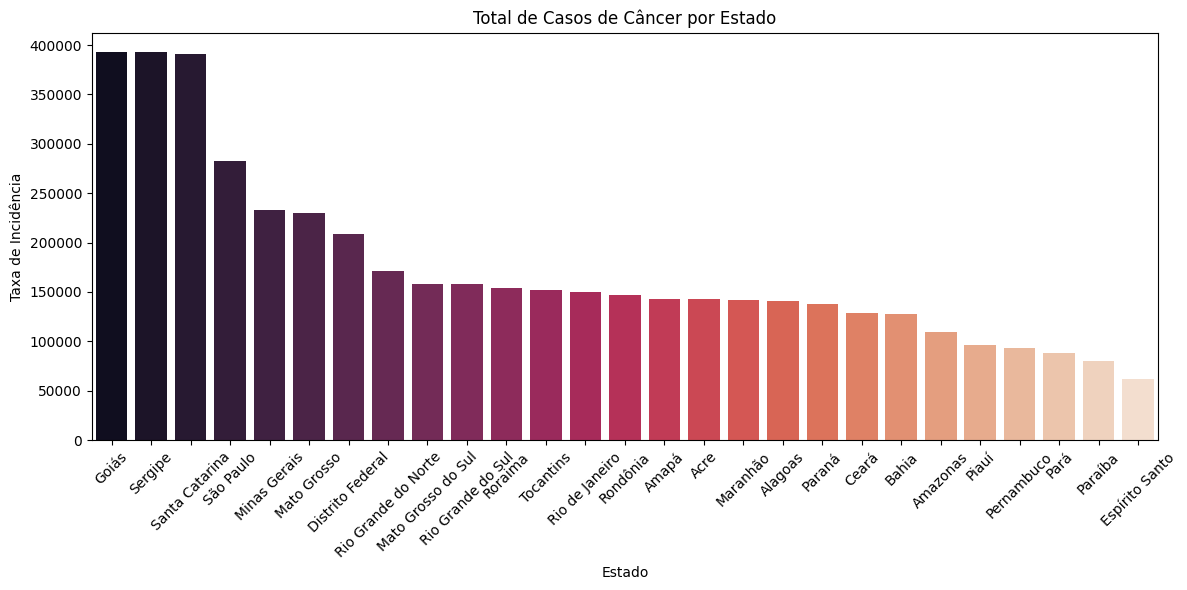

In [45]:
print(df.columns)

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='cancer_estado', y='total_incidencia', palette='rocket', hue='cancer_estado', dodge=False)

plt.title('Total de Casos de Câncer por Estado')
plt.xlabel('Estado')
plt.ylabel('Taxa de Incidência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

----

# Slice and Dice

### Qual foi a temperatura média da cidade X entre o ano Y e o ano Z?

In [55]:
CIDADE = 'São Paulo'
ANO_INICIAL = 2010
ANO_FINAL = 2020

query = f"""
SELECT
    a.cidade,
    AVG(CAST(f.temperatura_media AS DECIMAL)) AS temperatura_media
FROM
    fato_clima f
JOIN
    dim_localidade a ON a.localidade_pk = f.localidade_pk
JOIN
    dim_data b ON b.data_pk = f.data_pk
WHERE
    b.data_ano BETWEEN {ANO_INICIAL} AND {ANO_FINAL}
    AND a.cidade = '{CIDADE}'
GROUP BY
    a.cidade
"""

df = pd.read_sql(query, engine)
df.head()

,cidade,temperatura_media
0,São Paulo,19.810035


### Qual a taxa de câncer de pele em pessoas do sexo X com Y anos até Z anos de idade?

In [ ]:
SEXO = 'Feminino'
IDADE_INICIAL = 20
IDADE_FINAL = 60


query = f"""
SELECT 
    b.faixa_etaria,
    AVG(CAST(f.incidencia_cancer AS FLOAT)) AS total_incidencia
FROM
    fato_cancer f
JOIN
    dim_sexo a ON a.sexo_pk = f.sexo_pk
JOIN
    dim_faixa_etaria b ON b.faixa_pk = f.faixa_pk
JOIN 
    dim_metrica c ON c.metrica_pk = f.metrica_pk
WHERE
    a.sexo = '{SEXO}'
    AND c.tipo_metrica = 'Taxa'
    AND b.idade_min >= {IDADE_INICIAL}
    AND b.idade_max <= {IDADE_FINAL}
GROUP BY
    b.faixa_etaria
ORDER BY
    b.faixa_etaria ASC;
"""


df = pd.read_sql(query, engine)
df.head()

,faixa_etaria,total_incidencia
0,20-24,1.406052
1,25-29,2.537994
2,30-34,4.870052
3,35-39,8.430008
4,40-44,14.229566


---

# Pivot

### Qual o número de óbitos por câncer de pele por faixa etária para cada sexo?

In [ ]:
query = f"""
SELECT 
    b.faixa_etaria,
    a.sexo,
    SUM(CAST(f.obitos_cancer AS FLOAT)) AS total_obitos
FROM
    fato_cancer f
JOIN
    dim_sexo a ON a.sexo_pk = f.sexo_pk
JOIN
    dim_faixa_etaria b ON b.faixa_pk = f.faixa_pk
JOIN
    dim_metrica c ON c.metrica_pk = f.metrica_pk
WHERE
    c.tipo_metrica = 'Numero'
GROUP BY
    b.faixa_etaria, a.sexo
ORDER BY
    b.faixa_etaria ASC;
"""

df = pd.read_sql(query, engine)
df.head()


,faixa_etaria,sexo,total_obitos
0,10-14,Feminino,0.000
1,10-14,Masculino,0.000
2,15-19,Feminino,92.163
3,15-19,Masculino,118.620
4,2-4,Feminino,0.000


### Qual a média diária de radiação UVA e UVB em uma cidade X em um mês Y?

In [108]:
CIDADE = 'Araxá'
MES = '2'

query = f"""
SELECT 
    a.cidade,
    AVG(CAST(f.radiacao_uva AS DECIMAL)) AS UVA_media,
    AVG(CAST(f.radiacao_uvb AS DECIMAL)) AS UVB_media
FROM
    fato_clima f
JOIN
    dim_localidade a ON a.localidade_pk = f.localidade_pk
JOIN
    dim_data b ON b.data_pk = f.data_pk
WHERE
    a.cidade = '{CIDADE}'
    AND b.data_mes = '{MES}'
GROUP BY
    a.cidade
"""

df = pd.read_sql(query, engine)
df.head()


,cidade,uva_media,uvb_media
0,Araxá,1.328904,0.041922


---

# Drill-Across

### Qual a média anual de incidência de raios UV e da taxa de câncer de pele em uma determinada região do Brasil?

In [ ]:
CIDADE = 'Araxá'
MES = '2'

query = f"""
SELECT 
    a.região,
    AVG(CAST(f.radiacao_uva AS DECIMAL)) AS UVA_media,
    AVG(CAST(f.radiacao_uvb AS DECIMAL)) AS UVB_media
FROM
    fato_clima f
JOIN
    vw_estado a ON a.localidade_pk = f.localidade_pk
JOIN
    dim_data b ON b.data_pk = f.data_pk
WHERE
    a.cidade = '{CIDADE}'
    AND b.data_mes = '{MES}'
GROUP BY
    a.cidade
"""

df = pd.read_sql(query, engine)
df.head()
